In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import poisson

In [2]:
import os, glob

In [3]:
paths = glob.glob('./input/1/*.png')

In [4]:
paths

['./input/1\\mask.png', './input/1\\source.png', './input/1\\target.png']

In [5]:
img = cv2.imread('./input/1/source.png')
background = cv2.imread('./input/1/target.png')
mask = cv2.imread('./input/1/mask.png', cv2.IMREAD_GRAYSCALE) 

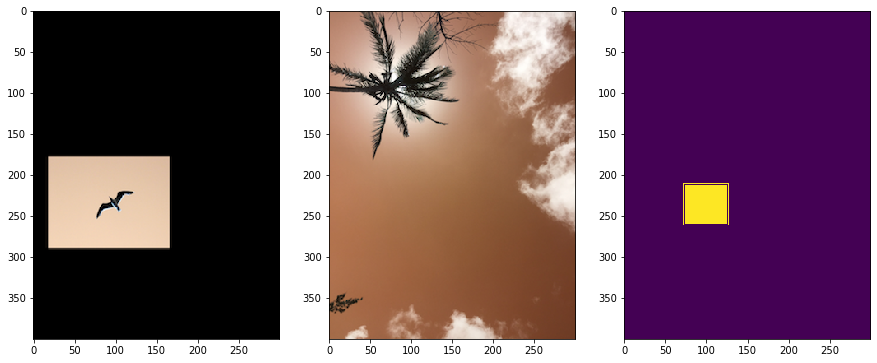

In [38]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(background)
plt.subplot(1,3,3)
plt.imshow(mask)

In [7]:
# Normalize mask to range [0,1]
mask = np.atleast_3d(mask).astype(np.float) / 255.

In [8]:
# Make mask binary
mask[mask != 1] = 0

In [9]:
# Trim to one channel
mask = mask[:,:,0]

In [10]:
channels = img.shape[-1]

In [30]:
# Call the poisson method on each individual channel
result_stack = [poisson.process(img[:,:,i], background[:,:,i], mask) for i in range(channels)]

In [31]:
# Merge the channels back into one image
result = cv2.merge(result_stack)

In [33]:
np.min(result)

-105

In [36]:
result2=np.copy(result)
result2[result2<0] = 255

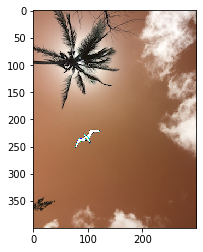

In [37]:
plt.imshow(result2)

In [24]:
result.dtype

dtype('int32')

In [28]:
# clip negative values
# result[result <0] = 0

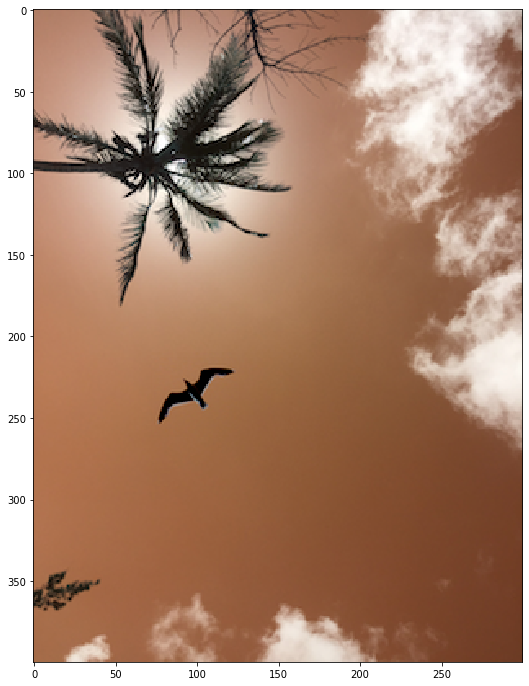

In [29]:
plt.figure(figsize=(12,12))
plt.imshow(result)

Problem: the channel values may become negative....

## Superimpose the stamp 

In [72]:
from skimage.morphology import remove_small_objects

In [57]:
img_ = cv2.imread('./input/3/source.png', cv2.IMREAD_UNCHANGED)

In [89]:
img_ = cv2.resize(img_, (int(226/335*484), 266))

In [96]:
# rgb image
img = img_[:,:,0:3]

In [97]:
mask = img_[:,:,3]

In [90]:
background = cv2.imread('./input/3/bg.jpg', cv2.IMREAD_UNCHANGED)

In [98]:
img_.shape

(266, 326, 4)

In [101]:
# cut background to image size
background = background[:img_.shape[0],:img_.shape[1],:]

In [102]:
mask_bw = remove_small_objects(mask>np.std(mask), min_size=5)

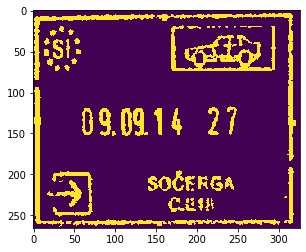

In [103]:
plt.imshow(mask_bw)

In [104]:
# Call the poisson method on each individual channel
result_stack = [poisson.process(img[:,:,i], background[:,:,i], mask_bw) for i in range(3)]

In [108]:
# Merge the channels back into one image
result = cv2.merge(result_stack)

In [110]:
np.min(result)

-24

In [111]:
np.max(result)

255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


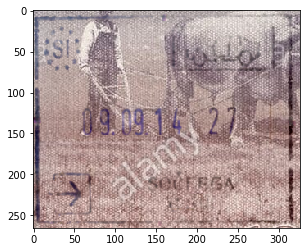

In [112]:
plt.imshow(result)

## New superimpose function

In [120]:
result_old = superimpose_img(background.astype(np.float), img_, (0,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


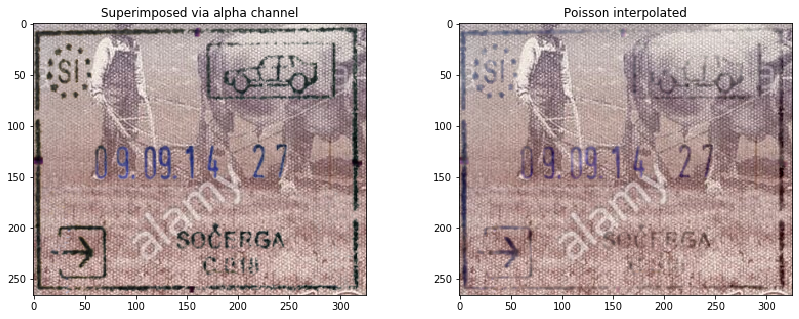

In [133]:
plt.figure(figsize=(14,5), facecolor=(1,1,1))
plt.subplot(1,2,1)
plt.imshow(result_old)
plt.title('Superimposed via alpha channel')
plt.subplot(1,2,2)
plt.imshow(result)
plt.title('Poisson interpolated')

plt.savefig('./comparison.png', dpi=100)
plt.show()


In [117]:
def superimpose_img(background,
                    img,
                    topleft,
                   ):
    '''
    Put character onto the background

    background --- 4 chnl background
    img        --- the imge to be superimposed
    '''

    # use alpha channel to kill background
    alpha = np.expand_dims(img[:,:,3], axis=2)
    alpha = alpha / np.max(alpha)
    img = img * alpha


    top, left = topleft
    height, width, _ = img.shape

    # softly remove the background where the symbol must be
    background[top:top + height, left:left+width] *= (1-alpha)

    # superimpose the image onto the background
    background[top:top + height, left:left+width] += img[:,:,0:3]


    # Mem clean
    del img
    del alpha

    return np.asarray(background, dtype = np.int32)